In [1]:
import transformers
print(transformers.__version__)


4.57.0


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",use_fast=True)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [20]:
# train-test split
small_train = dataset["train"].shuffle(seed=42).select(range(10000))
small_test  = dataset["test"].shuffle(seed=42).select(range(5000))

In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [21]:
import transformers
print(transformers.__version__)
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
import evaluate
import numpy as np

# model
model_full = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

# (ensure every param is trainable)
for p in model_full.parameters():
    p.requires_grad = True

# metrics
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        **acc.compute(predictions=preds, references=labels),
        **f1.compute(predictions=preds, references=labels, average="macro")
    }

# NOTE: no evaluation_strategy here
training_args_full = TrainingArguments(
    output_dir="./results_full",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=1,
    report_to="none",
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50
)

trainer_full = Trainer(
    model=model_full,
    args=training_args_full,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics
)

trainer_full.train()
# print(trainer_full.evaluate())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4.57.0


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.584100,0.365471,0.851000,0.850635
100,0.343700,0.298876,0.873200,0.872972
150,0.310800,0.287808,0.877600,0.877084
200,0.297300,0.264420,0.890000,0.889876
250,0.285500,0.268936,0.894200,0.894153
300,0.283500,0.254364,0.896000,0.895980
350,0.209300,0.295475,0.886200,0.885797
400,0.191100,0.263457,0.901400,0.901340
450,0.214200,0.276667,0.892600,0.892329
500,0.181300,0.270624,0.896200,0.896029


TrainOutput(global_step=626, training_loss=0.27248494693646413, metrics={'train_runtime': 275.8577, 'train_samples_per_second': 72.501, 'train_steps_per_second': 2.269, 'total_flos': 1324673986560000.0, 'train_loss': 0.27248494693646413, 'epoch': 2.0})

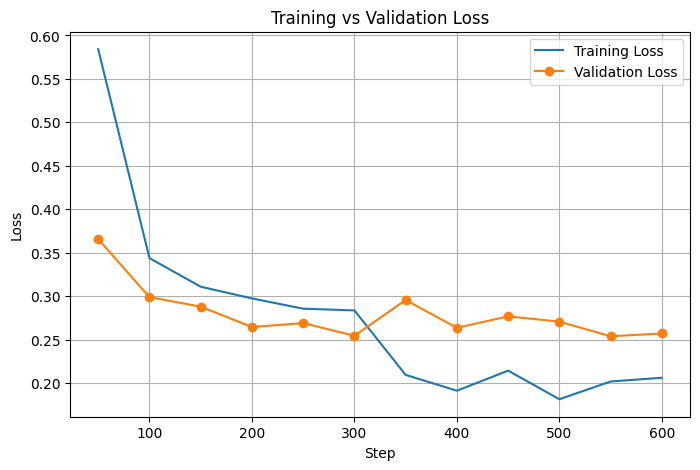

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer_full.state.log_history)

# Keep only the columns we need and drop rows without those values
train_df = logs.loc[logs["loss"].notna(), ["step", "loss"]]
val_df   = logs.loc[logs["eval_loss"].notna(), ["step", "eval_loss"]]

plt.figure(figsize=(8,5))
plt.plot(train_df["step"], train_df["loss"], label="Training Loss")
plt.plot(val_df["step"],   val_df["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.show()


In [23]:
from peft import LoraConfig, get_peft_model
import torch
lora_cfg = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]
)
model_lora = get_peft_model(model_full, lora_cfg)
model_lora.print_trainable_parameters()  # sanity check

# ===== Metrics =====
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        **acc.compute(predictions=preds, references=labels),
        **f1.compute(predictions=preds, references=labels, average="macro")
    }

# Mixed precision (bf16 on Ampere+, else fp16 if GPU)
bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
fp16_ok = torch.cuda.is_available() and not bf16_ok

# ===== Training args =====
training_args = TrainingArguments(
    output_dir="./results_lora",
    learning_rate=2e-4,                 # LoRA usually tolerates higher LR than full FT
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_total_limit=1,
    report_to="none",
    bf16=bf16_ok,
    fp16=fp16_ok
)

# ===== Trainer =====
trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics
)

# ===== Train & evaluate =====
trainer.train()
# results = trainer.evaluate()
# print(results)  # {'eval_loss', 'eval_accuracy', 'eval_f1', ...}



trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


Step,Training Loss,Validation Loss,Accuracy,F1
50,0.190900,0.278173,0.901200,0.901183
100,0.157700,0.280332,0.898600,0.898546
150,0.151300,0.273273,0.901200,0.901194
200,0.157100,0.278481,0.899000,0.898898
250,0.150600,0.269925,0.902200,0.902196
300,0.159300,0.270399,0.902200,0.902195
350,0.133700,0.271911,0.900200,0.900159
400,0.119800,0.288810,0.899400,0.899354
450,0.160900,0.270445,0.901000,0.900967
500,0.128700,0.277791,0.899200,0.899153


TrainOutput(global_step=626, training_loss=0.15581781947955536, metrics={'train_runtime': 211.1248, 'train_samples_per_second': 94.731, 'train_steps_per_second': 2.965, 'total_flos': 1347394068480000.0, 'train_loss': 0.15581781947955536, 'epoch': 2.0})

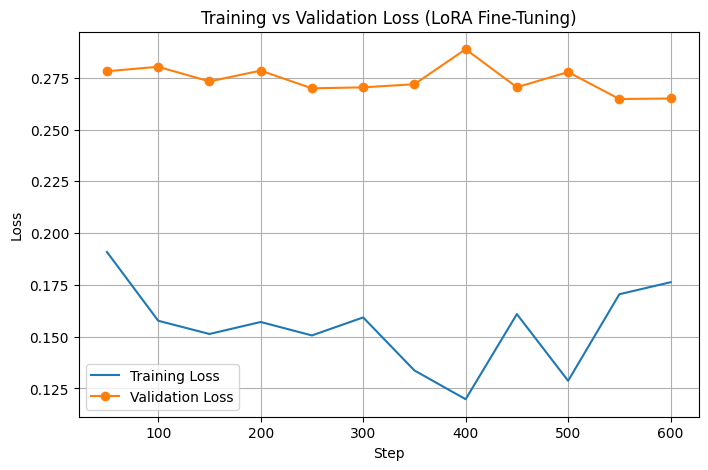

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

# Filter out the steps with recorded training or validation loss
train_df = logs.loc[logs["loss"].notna(), ["step", "loss"]]
val_df   = logs.loc[logs["eval_loss"].notna(), ["step", "eval_loss"]]

plt.figure(figsize=(8,5))
plt.plot(train_df["step"], train_df["loss"], label="Training Loss")
plt.plot(val_df["step"], val_df["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (LoRA Fine-Tuning)")
plt.legend()
plt.grid(True)
plt.show()
